In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

In [2]:
def loadData(path):
    data = pd.read_csv(path)
    return data

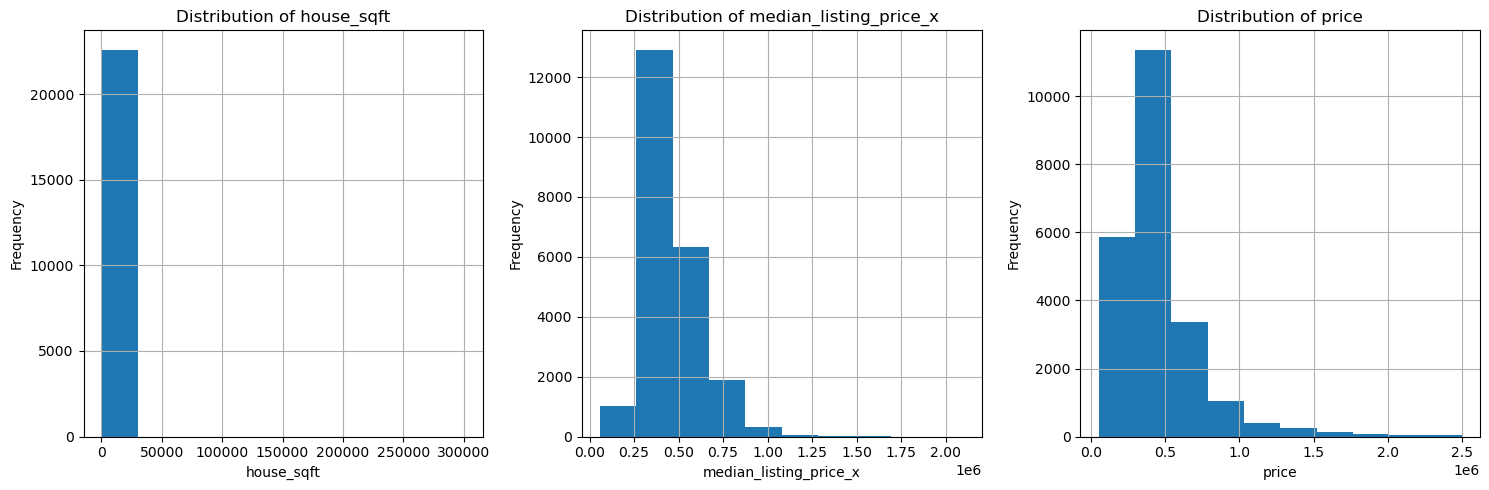

In [3]:
data = loadData("dataset.csv")

imputer_mean = SimpleImputer(strategy='mean')
imputer_median = SimpleImputer(strategy='median')

mean_impute_cols = ['hotness_score', 'nielsen_hh_rank', 'demand_score', 'supply_score',
                    'median_listing_price_vs_us', 'median_dom_vs_us', 'avg_int_rate']
median_impute_cols = [col for col in data.columns if col not in mean_impute_cols and data[col].isnull().any()]

for col in mean_impute_cols:
    if col in data.columns:
        data[col] = imputer_mean.fit_transform(data[[col]])

for col in median_impute_cols:
    data[col] = imputer_median.fit_transform(data[[col]])

data_encoded = pd.get_dummies(data, columns=['city', 'state'])
data_encoded['date'] = pd.to_datetime(data_encoded['date'])
data_encoded['year'] = data_encoded['date'].dt.year
data_encoded['month'] = data_encoded['date'].dt.month
data_encoded.drop(columns=['date'], inplace=True)
data_encoded.drop(columns=['address'], inplace=True)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
columns_to_plot = ['house_sqft', 'median_listing_price_x', 'price']

for ax, column in zip(axes, columns_to_plot):
    data_encoded[column].hist(ax=ax)
    ax.set_title(f'Distribution of {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

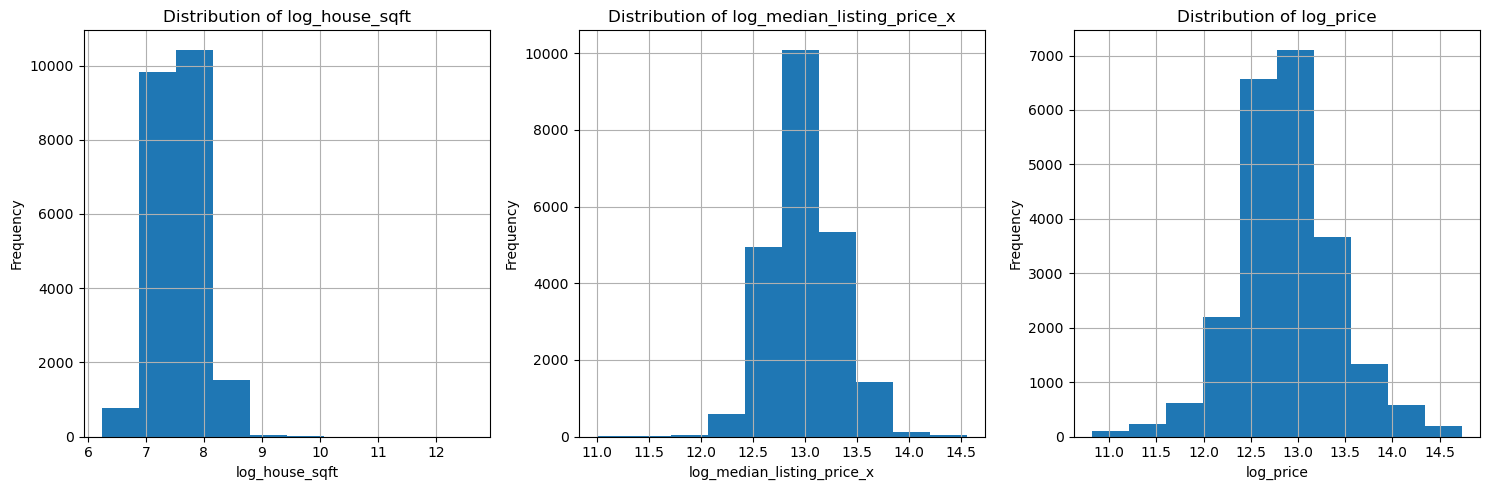

In [4]:
for column in ['house_sqft', 'median_listing_price_x', 'price']:
    data_encoded[f'log_{column}'] = np.log1p(data_encoded[column])

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
transformed_columns = ['log_house_sqft', 'log_median_listing_price_x', 'log_price']

for ax, column in zip(axes, transformed_columns):
    data_encoded[column].hist(ax=ax)
    ax.set_title(f'Distribution of {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

X = data_encoded[['median_square_feet', 'bed', 'median_listing_price_per_square_foot', 
                  'average_listing_price', 'median_listing_price_vs_us', 'median_listing_price_x', 
                  'log_median_listing_price_x', 'zhvi', 'bath', 'log_house_sqft']]
y = data_encoded['log_price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", rmse)

RMSE: 0.2521251240377596


In [6]:
key_features = ['log_house_sqft', 'log_median_listing_price_x', 'zhvi', 'bath']
X_key_features = X[key_features]

X_train_key, X_test_key, y_train_key, y_test_key = train_test_split(X_key_features, y, test_size=0.3, random_state=42)

rf_model_simplified = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_simplified.fit(X_train_key, y_train_key)

y_pred_key = rf_model_simplified.predict(X_test_key)

rmse_key = np.sqrt(mean_squared_error(y_test_key, y_pred_key))
print("Simplified Model RMSE:", rmse_key)

Simplified Model RMSE: 0.26297717040910423


In [7]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

param_grid = {
    'n_estimators': [50, 100, 200],  
    'max_depth': [None, 10, 20],     
    'min_samples_split': [2, 10],    
    'min_samples_leaf': [1, 4]       
}

grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
                           param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
grid_search.fit(X_train_key, y_train_key)

best_params = grid_search.best_params_
best_rmse = np.sqrt(-grid_search.best_score_)

print("Best Parameters:", best_params)
print("Best RMSE:", best_rmse)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best Parameters: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Best RMSE: 0.262102084127585


In [8]:
from sklearn.preprocessing import PolynomialFeatures
import pandas as pd

features_for_poly = X[['log_house_sqft', 'zhvi']]

poly_transformer = PolynomialFeatures(degree=2, include_bias=False)

features_poly = poly_transformer.fit_transform(features_for_poly)

features_poly_df = pd.DataFrame(features_poly, 
                                columns=poly_transformer.get_feature_names(features_for_poly.columns))

print(features_poly_df.head())

   log_house_sqft           zhvi  log_house_sqft^2  log_house_sqft zhvi  \
0        7.999007  376614.486533         63.984116         3.012542e+06   
1        8.351847  376614.486533         69.753344         3.145426e+06   
2        7.967627  376614.486533         63.483076         3.000724e+06   
3        7.729296  373627.522281         59.742012         2.887878e+06   
4       12.614869  373627.522281        159.134917         4.713262e+06   

         zhvi^2  
0  1.418385e+11  
1  1.418385e+11  
2  1.418385e+11  
3  1.395975e+11  
4  1.395975e+11  


C:\Users\GRICE_D\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

import pandas as pd

features_poly_df.reset_index(drop=True, inplace=True)

X_extended = pd.concat([X, features_poly_df], axis=1)

X_train_ext, X_test_ext, y_train_ext, y_test_ext = train_test_split(X_extended, y, test_size=0.3, random_state=42)

rf_model_extended = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_extended.fit(X_train_ext, y_train_ext)

y_pred_ext = rf_model_extended.predict(X_test_ext)

rmse_extended = np.sqrt(mean_squared_error(y_test_ext, y_pred_ext))
print("Extended Model RMSE:", rmse_extended)

Extended Model RMSE: 0.2522213203667032
